# Supervised Sentiment Analysis 

In [47]:
import tweepy
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import nltk
import re
import gensim
import matplotlib.pyplot as plt

from nltk.stem.wordnet import WordNetLemmatizer
from tweepy import OAuthHandler 
from wordcloud import WordCloud
from nltk.corpus import stopwords
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.models import Sequential
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping



## Training Data- Labeled

In [3]:
df = pd.read_csv('training.csv',encoding='latin-1',header=None)
df = df .drop([1,2,3,4],axis=1)


0                                                  5
0        0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1        0  is upset that he can't update his Facebook by ...
2        0  @Kenichan I dived many times for the ball. Man...
3        0    my whole body feels itchy and like its on fire 
4        0  @nationwideclass no, it's not behaving at all....
...     ..                                                ...
1599995  4  Just woke up. Having no school is the best fee...
1599996  4  TheWDB.com - Very cool to hear old Walt interv...
1599997  4  Are you ready for your MoJo Makeover? Ask me f...
1599998  4  Happy 38th Birthday to my boo of alll time!!! ...
1599999  4  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]

In [4]:
df.columns = ['Sentiment','Tweet']
df['Sentiment'] = df['Sentiment'].replace(4,1)
df

Sentiment                                              Tweet
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          1  Just woke up. Having no school is the best fee...
1599996          1  TheWDB.com - Very cool to hear old Walt interv...
1599997          1  Are you ready for your MoJo Makeover? Ask me f...
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]

In [5]:
df['Sentiment'].value_counts()

1    800000
0    800000
Name: Sentiment, dtype: int64

Text(0.5, 1.0, 'Dataset labels distribuition')

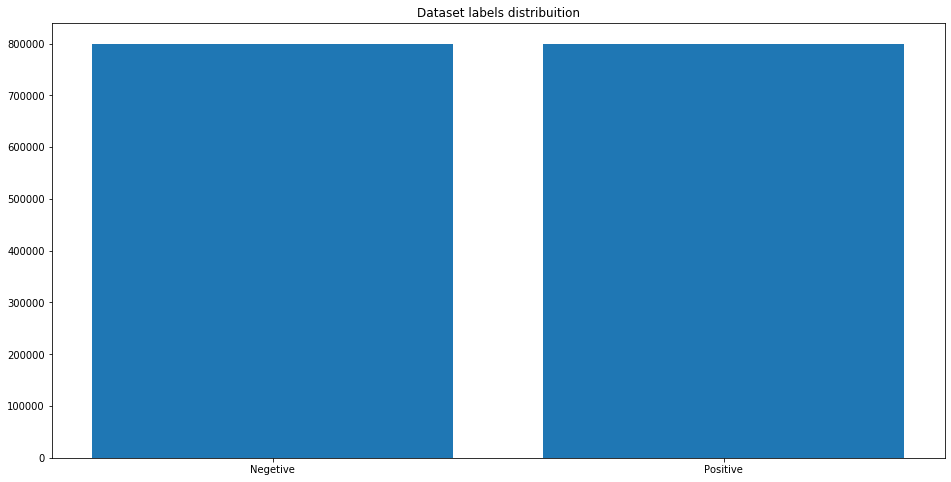

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.bar(['Negetive','Positive'], df['Sentiment'].value_counts())
plt.title("Dataset labels distribuition")

## Preprocessing

1. Remove special characters
2. Remove white spaces
3. Convert to lower case
4. Remove stopwords
6. Remove non ascii words
5. Lemmetization


In [37]:
def preprocess(df,stop,words):    
    df['Tweet'] = df['Tweet'].map(lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x)) # remove special charcters
    df['Tweet'] = df['Tweet'].str.strip() 
    df['Tweet'] = df['Tweet'].str.lower()
    df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))      
    return df
def remove_nonascii(sentence):
    tokens = sentence.split()
    sent = " ".join(w for w in tokens if w.lower() in words or not w.isalpha())     
    return sent
    
def lemmatize(sentence):
    lemmatizing = WordNetLemmatizer()
    tokens = sentence.split()
    stemmed_tokens = [lemmatizing.lemmatize(token) for token in tokens]
    return ' '.join(stemmed_tokens)

    

In [22]:
stop = stopwords.words('english') # stop words from nltk
words = set(nltk.corpus.words.words()) # ascii words nltk

df = preprocess(df,stop,words)
df['Tweet'] = df['Tweet'].apply(remove_nonascii)
df['Tweet_cleaned'] = df['Tweet'].apply(lemmatize)

## World Cloud

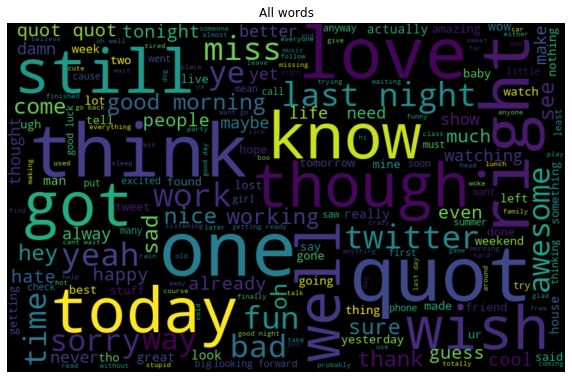

In [23]:
all_words = ' '.join([text for text in df['Tweet_cleaned']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("All words")
plt.show()

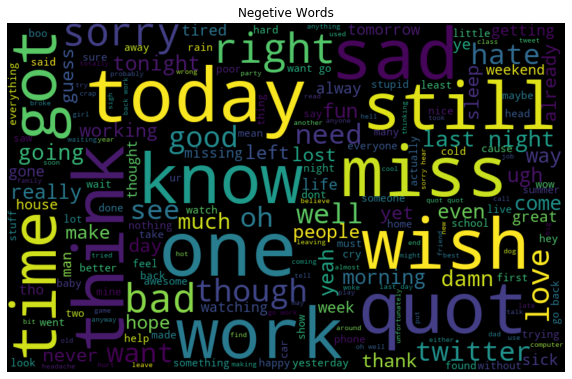

In [24]:
normal_words =' '.join([text for text in df['Tweet_cleaned'][df['Sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Negetive Words")
plt.show()

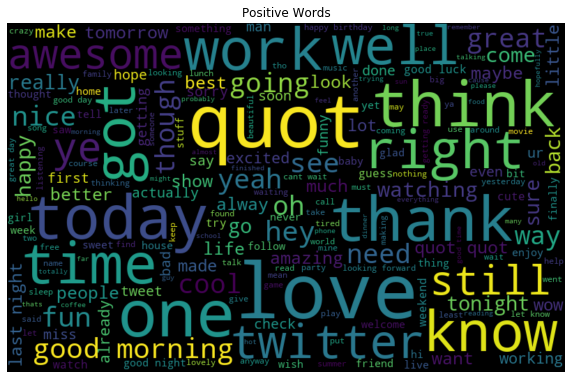

In [26]:
normal_words =' '.join([text for text in df['Tweet_cleaned'][df['Sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Positive Words")
plt.show()

## Train Test Split

In [29]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [32]:
documents = [_text.split() for _text in df_train.Tweet_cleaned] 

## Word2Vec

In [33]:
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_MIN_COUNT = 10

# train word2vec model
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE,window=W2V_WINDOW,min_count=W2V_MIN_COUNT,workers=8)
w2v_model.build_vocab(documents)


In [34]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)


Vocab size 13202


In [35]:
w2v_model.train(documents, total_examples=len(documents), epochs=50)

(299984622, 341762700)

In [36]:
w2v_model.most_similar("bad")

C:\Users\namit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('terrible', 0.671310305595398),
 ('horrible', 0.6552526950836182),
 ('awful', 0.6194040775299072),
 ('good', 0.5205410122871399),
 ('worse', 0.4745559096336365),
 ('like', 0.4462709426879883),
 ('worst', 0.430738627910614),
 ('sick', 0.4233725965023041),
 ('better', 0.42293792963027954),
 ('upset', 0.41918712854385376)]

## Tokenize, Padding, Embedding

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Tweet_cleaned)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 45270


In [41]:
# pad sequnce to make all sentences equal length 
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Tweet_cleaned), maxlen=W2V_SIZE)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Tweet_cleaned), maxlen=W2V_SIZE)

In [42]:
y_train = df_train['Sentiment']
y_test = df_test['Sentiment']

y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)


y_train (1280000, 1)
y_test (320000, 1)


In [43]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)

print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 200)
y_train (1280000, 1)

x_test (320000, 200)
y_test (320000, 1)


In [44]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)


(45270, 200)


In [50]:

embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=W2V_SIZE, trainable=False)

In [52]:

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          9054000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 200)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 9,174,501
Trainable params: 120,501
Non-trainable params: 9,054,000
_________________________________________________________________


In [53]:
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [54]:
history = model.fit(x_train, y_train,
                    batch_size=1500,
                    epochs=10,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
768/768 [==============================] - 12042s 16s/step - loss: 0.5458 - accuracy: 0.7163 - val_loss: 0.5145 - val_accuracy: 0.7468
Epoch 2/10
768/768 [==============================] - 10208s 13s/step - loss: 0.5244 - accuracy: 0.7332 - val_loss: 0.5061 - val_accuracy: 0.7502
Epoch 3/10
768/768 [==============================] - 64810s 84s/step - loss: 0.5182 - accuracy: 0.7375 - val_loss: 0.5010 - val_accuracy: 0.7527
Epoch 4/10
768/768 [==============================] - 10657s 14s/step - loss: 0.5155 - accuracy: 0.7394 - val_loss: 0.5002 - val_accuracy: 0.7545
Epoch 5/10
768/768 [==============================] - 9097s 12s/step - loss: 0.5131 - accuracy: 0.7413 - val_loss: 0.4997 - val_accuracy: 0.7548
Epoch 6/10
768/768 [==============================] - 17853s 23s/step - loss: 0.5115 - accuracy: 0.7421 - val_loss: 0.4978 - val_accuracy: 0.7559
Epoch 7/10
768/768 [==============================] - 45686s 59s/step - loss: 0.5103 - accuracy: 0.7429 - val_loss: 0.4962 - 

In [55]:

score = model.evaluate(x_test, y_test, batch_size=1000)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320/320 [==============================] - 515s 2s/step - loss: 0.4961 - accuracy: 0.7563

ACCURACY: 0.7563281059265137
LOSS: 0.49609115719795227


In [64]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [88]:
len(x_test[0])

200

## Prediction on Live Twitter data on most trending topic

In [56]:
# Your Twittter App Credentials
consumer_key = "FOf9R1Sw6QDXYwE6JU88DTv9t"
consumer_secret = "j6c1GE4Dhsoz3KQpAd6IdRXn7KO7S8NSnieIixifexC3UXmuCp"
access_token = "1306880171488624641-DybGw9dWM81Xqhx4oKLtNYlsqIeKfb"
access_token_secret = "NnIbnn5cQ8jfJLtBvmjdIEeQelbZRtY5qrjasFpy10rCt"
 
# Calling API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
 
# http://woeid.rosselliot.co.nz/lookup/india
INDIA_WOE_ID = 23424848
 
# https://developer.twitter.com/en/docs/trends/trends-for-location/api-reference/get-trends-place
india_trends = api.trends_place(INDIA_WOE_ID)
trending_name, volume = [],[]
for trending in india_trends[0]['trends']:
    print(trending['name'], '-----' , trending['tweet_volume'])
    trending_name.append(trending['name'])
    volume.append( trending['tweet_volume'])

#TurbineTales ----- 28179
#JusticeForBabuPujari ----- 139419
#BrahminLivesMatter ----- 25417
#BabaKaOnlineDhaba ----- None
#राममंदिर_से_रामराज्य ----- None
REAL ENTERTAINER SIDHARTH ----- 15011
lets talk urticaria ----- None
Oxygen ----- 110236
Jinnie ----- 13886


In [57]:

# Set notebook mode to work in offline
py.init_notebook_mode()
# langs = trending_name
# students = [23,17,35,29,12]
data = [go.Bar(
   x = trending_name,
   y = volume
)]
fig = go.Figure(data=data)
py.iplot(fig)

In [113]:
MAX_TWEETS = 100
trending_hastag = trending_name[0]
msgs = []
msg =[]

for tweet in tweepy.Cursor(api.search, q=str(trending_hastag), rpp=100).items(MAX_TWEETS):
    msg = [tweet.text, tweet.source, tweet.source_url] 
#     msg = tuple(msg)                    
    msgs.append(msg)

tweets = pd.DataFrame(msgs)
tweets.columns = ['Tweet', 'source', 'url']
tweets

Tweet               source  \
0   RT @Troll_Modi: आपने देखा होगा कि रसोई में जब ...  Twitter for Android   
1   RT @sakshijoshii: Wind turbine रिपब्लिक की छत ...  Twitter for Android   
2   RT @sneha2986: Bhakts have gone into hiding to...  Twitter for Android   
3   RT @aadhiIa: नरेंद्र मोदी को साइंस उतनी ही आती...  Twitter for Android   
4   RT @kroor_singh_: Modi ji's way of producing o...  Twitter for Android   
..                                                ...                  ...   
95  RT @Antonio420_786: For those Dumb people who ...      Twitter Web App   
96  RT @RoflGandhi_: Delhi ke batsmen agar bat ki ...  Twitter for Android   
97  RT @SimmiAhuja_: बार बार theatre मे एक ही movi...  Twitter for Android   
98  RT @paddy_064: मोदींजीचा ऑक्सिजन वेगळा करण्याच...      Twitter Web App   
99  RT @dhrubachoudhur5: @smritiirani ji since our...  Twitter for Android   

                                    url  
0   http://twitter.com/download/android  
1   http://twitter.com/download/android  
2   http://twitter.com/download/android  
3   http://twitter.com/download/android  
4   http://twitter.com/download/android  
..                                  ...  
95           https://mobile.twitter.com  
96  http://twitter.com/download/android  
97  http://twitter.com/download/android  
98           https://mobile.twitter.com  
99  http://twitter.com/download/android  

[100 rows x 3 columns]

In [114]:
tweets = preprocess(tweets,stop,words)
tweets['Tweet'] = tweets['Tweet'].apply(remove_nonascii)
tweets['Tweet_cleaned'] = tweets['Tweet'].apply(lemmatize)


In [115]:
tweets['Tweet_cleaned'][1]

'wind'

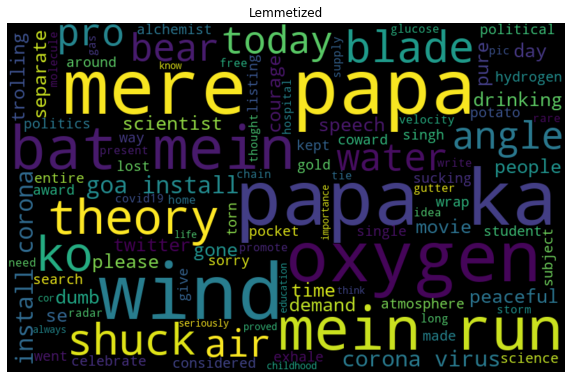

In [116]:
all_words = ' '.join([text for text in tweets['Tweet_cleaned']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Lemmetized")
plt.show()

In [117]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets.Tweet_cleaned)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

# pad sequnce to make all sentences equal length 
test = pad_sequences(tokenizer.texts_to_sequences(tweets.Tweet_cleaned), maxlen=W2V_SIZE)
 


Total words 116


In [118]:
pred = model.predict(test)

In [130]:
output = pd.DataFrame()
output['Original_Tweet'] = tweets['Tweet']
output['Sentiment'] = pred
output['Sentiment'] = output['Sentiment'].apply(lambda x: 'Positive' if x >= 0.4 else 'Negetive')   
output = output.dropna(how='any',axis=0) 
output

Original_Tweet Sentiment
0                                                      Positive
1                                                wind  Positive
2                     gone today peaceful day twitter  Positive
3                                                      Positive
4                                    singh way oxygen  Negetive
..                                                ...       ...
95     786 dumb people trolling theory please courage  Negetive
96                                       bat mein run  Positive
97                                       movie demand  Positive
98                                                064  Positive
99  since childhood know importance education life...  Negetive

[100 rows x 2 columns]

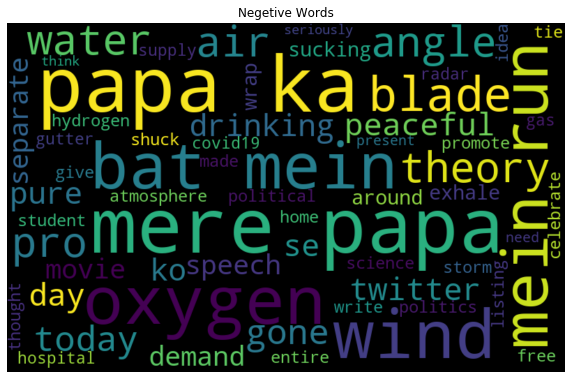

In [120]:
normal_words =' '.join([text for text in output['Original_Tweet'][output['Sentiment'] == 'Positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Negetive Words")
plt.show()

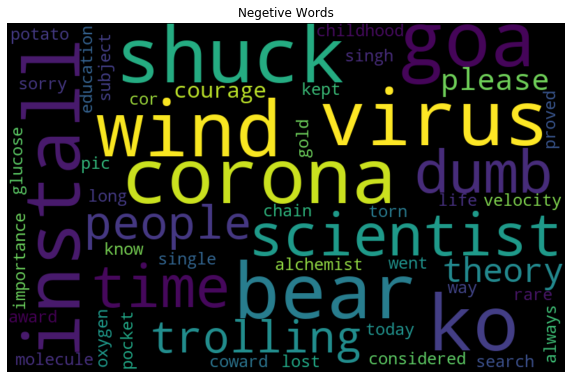

In [121]:
normal_words =' '.join([text for text in output['Original_Tweet'][output['Sentiment'] == 'Negetive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Negetive Words")
plt.show()

Text(0.5, 1.0, '#TurbineTales')

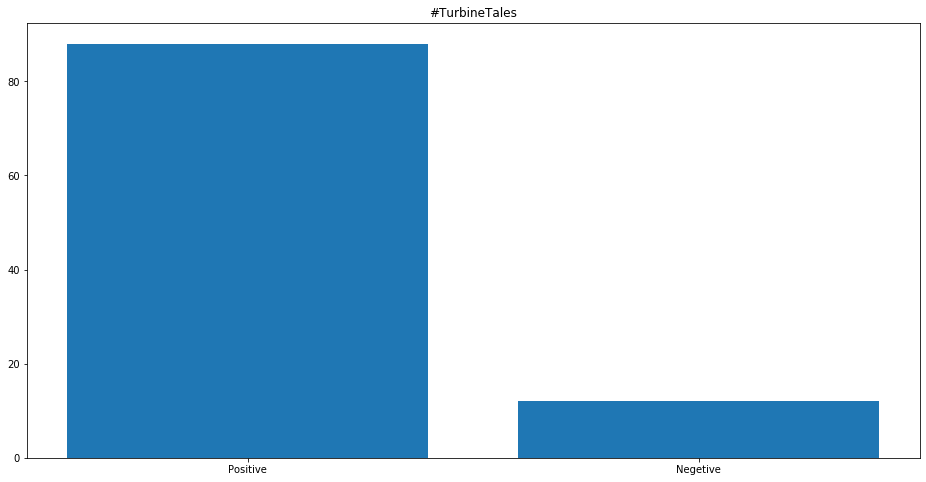

In [129]:

plt.figure(figsize=(16,8))
plt.bar(output['Sentiment'].unique(),output['Sentiment'].value_counts())
plt.title(trending_hastag)